#### Reference :
* https://www.kaggle.com/demetrypascal/better-train-csv-format-keras-starter
* https://www.kaggle.com/rsamdev/kaggle-starter-keras
* https://www.kaggle.com/arnabs007/apple-leaf-diseases-with-inceptionresnetv2-keras
* https://www.kaggle.com/emorkrin/baseline-keras-17-04/data#GoogLeNet

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.listdir('/kaggle/input/plant-pathology-2021-fgvc8/')

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

In [3]:
import pandas as pd
import numpy as np
import os
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, Xception, InceptionResNetV2, MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')
%matplotlib inline

In [4]:
train_df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
test_df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
print("Dataset Shape: ",train_df.shape)
train_df.head()

Dataset Shape:  (18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [5]:
train_df['labels'] = train_df['labels'].apply(lambda x: tuple(x.split(" ")))
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,"(healthy,)"
1,8002cb321f8bfcdf.jpg,"(scab, frog_eye_leaf_spot, complex)"
2,80070f7fb5e2ccaa.jpg,"(scab,)"
3,80077517781fb94f.jpg,"(scab,)"
4,800cbf0ff87721f8.jpg,"(complex,)"


In [6]:
datapath = glob('/kaggle/input/plant-pathology-2021-fgvc8/train_images/*')
print("Image Datasets Shape: ", len(datapath))

Image Datasets Shape:  18632


# EDA
* Labels per Value Percent
* Plot Sample Images

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


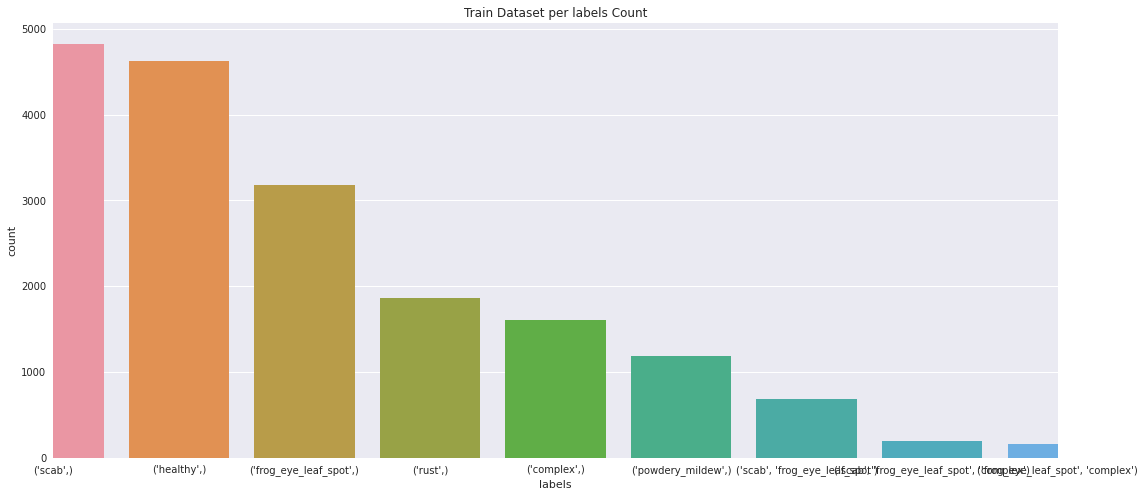

In [7]:
f,ax = plt.subplots(1,1,figsize=(18,8))
ax = sns.countplot(train_df['labels'], order=train_df['labels'].value_counts().sort_values(ascending=False).index)
ax.set_xlim(0,8)
ax.set_title('Train Dataset per labels Count')
plt.show()

In [8]:
train_df['labels'].value_counts()

(scab,)                                4826
(healthy,)                             4624
(frog_eye_leaf_spot,)                  3181
(rust,)                                1860
(complex,)                             1602
(powdery_mildew,)                      1184
(scab, frog_eye_leaf_spot)              686
(scab, frog_eye_leaf_spot, complex)     200
(frog_eye_leaf_spot, complex)           165
(rust, frog_eye_leaf_spot)              120
(rust, complex)                          97
(powdery_mildew, complex)                87
Name: labels, dtype: int64

In [9]:
unique_list = np.unique(train_df['labels'])
print(unique_list)
print(train_df['labels'].value_counts().count())

[('complex',) ('frog_eye_leaf_spot',) ('frog_eye_leaf_spot', 'complex')
 ('healthy',) ('powdery_mildew',) ('powdery_mildew', 'complex') ('rust',)
 ('rust', 'complex') ('rust', 'frog_eye_leaf_spot') ('scab',)
 ('scab', 'frog_eye_leaf_spot') ('scab', 'frog_eye_leaf_spot', 'complex')]
12


In [10]:
def read_image(path):
    path = os.path.join('../input/plant-pathology-2021-fgvc8/train_images',path["image"])
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype = tf.float32)
                  
    return image

In [11]:
def get_label(path):
    return path['labels']

In [12]:
def get_label_image(path):
    label = get_label(path)
    image = read_image(path)
    return label, image

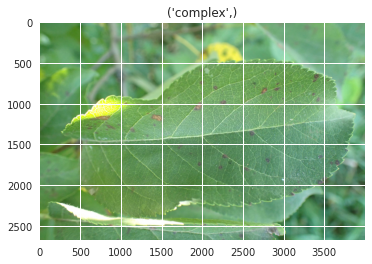

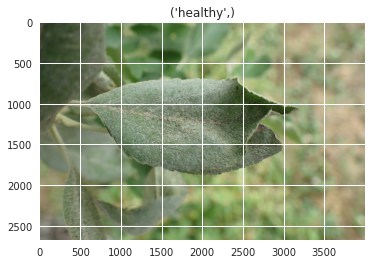

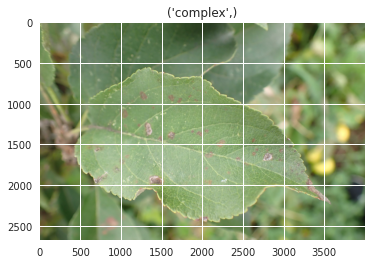

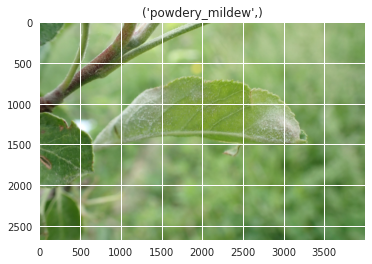

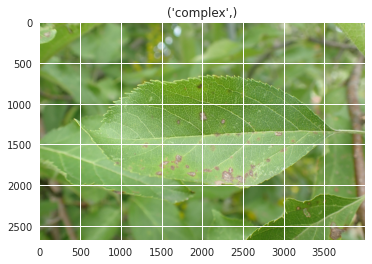

In [13]:
index_list = np.random.randint(128, size=5)
for i in index_list:
    path = train_df.iloc[i]
    sample_label, sample_image = get_label_image(path)
    plt.imshow(sample_image)
    plt.title(sample_label)
    plt.show()

# Feature Engineering
* Split Train / Validation Data
* Image Data Generate

In [14]:
INPUT_SIZE = (256,256,3)
BATCH_SIZE = 32
CLASSES = train_df['labels'].unique().tolist() # 12 classes

In [15]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.07, 
    zoom_range= 0.1, 
    horizontal_flip = True,
    validation_split=0.2
)

In [16]:
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory="../input/plant-pathology-2021-fgvc8/train_images",
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2],
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    train_df,
    directory="../input/plant-pathology-2021-fgvc8/train_images",
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2],
    subset='validation'
)

Found 14906 validated image filenames belonging to 6 classes.
Found 3726 validated image filenames belonging to 6 classes.


In [17]:
train_generator.class_indices

{'complex': 0,
 'frog_eye_leaf_spot': 1,
 'healthy': 2,
 'powdery_mildew': 3,
 'rust': 4,
 'scab': 5}

In [18]:
for x, y in train_generator:
    break

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


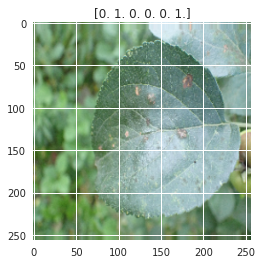

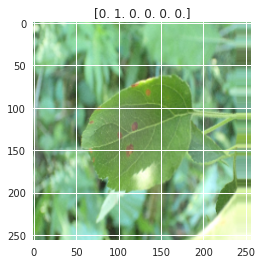

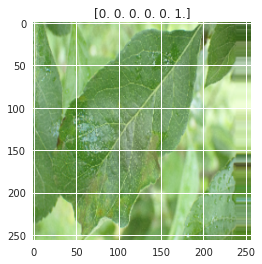

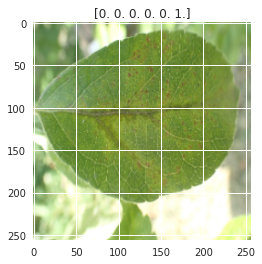

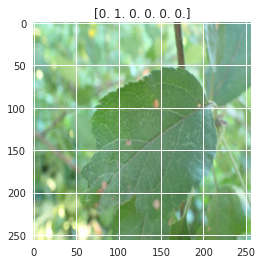

In [19]:
for i in range(5):
    plt.title(y[i])
    plt.imshow(x[i])
    plt.show()

# Modeling
* DenseNet 169

In [20]:
weights_path = "../input/keras-pretrained-imagenet-weights/densenet169_imagenet_1000_no_top.h5"

In [21]:
pre_model = DenseNet169(include_top=False, weights=weights_path, input_shape=INPUT_SIZE)

In [22]:
model = tf.keras.Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 106496)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               13631616  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 26,275,270
Trainable params: 26,116,870
Non-trainable params: 158,400
_________________________________________________________________


In [24]:
# you can use this callback func
callback= ReduceLROnPlateau(monitor='val_loss',
                       factor=.01, 
                       patience=3, 
                       min_lr=1e-5) 

In [25]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator)//BATCH_SIZE,
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator)//BATCH_SIZE
)

Epoch 1/15
14/14 [==============================] - 122s 8s/step - loss: 4.1249 - accuracy: 0.2522 - val_loss: 2.2706 - val_accuracy: 0.3125
Epoch 2/15
14/14 [==============================] - 100s 7s/step - loss: 1.7553 - accuracy: 0.3969 - val_loss: 2.1617 - val_accuracy: 0.3333
Epoch 3/15
14/14 [==============================] - 99s 7s/step - loss: 1.6520 - accuracy: 0.6415 - val_loss: 2.6660 - val_accuracy: 0.3958
Epoch 4/15
14/14 [==============================] - 97s 7s/step - loss: 1.9363 - accuracy: 0.6065 - val_loss: 4.3433 - val_accuracy: 0.1979
Epoch 5/15
14/14 [==============================] - 98s 7s/step - loss: 2.7473 - accuracy: 0.6020 - val_loss: 6.0125 - val_accuracy: 0.3021
Epoch 6/15
14/14 [==============================] - 97s 7s/step - loss: 5.1360 - accuracy: 0.5007 - val_loss: 11.2453 - val_accuracy: 0.2917
Epoch 7/15
14/14 [==============================] - 98s 7s/step - loss: 10.2522 - accuracy: 0.4973 - val_loss: 16.7835 - val_accuracy: 0.4167
Epoch 8/15
14/1

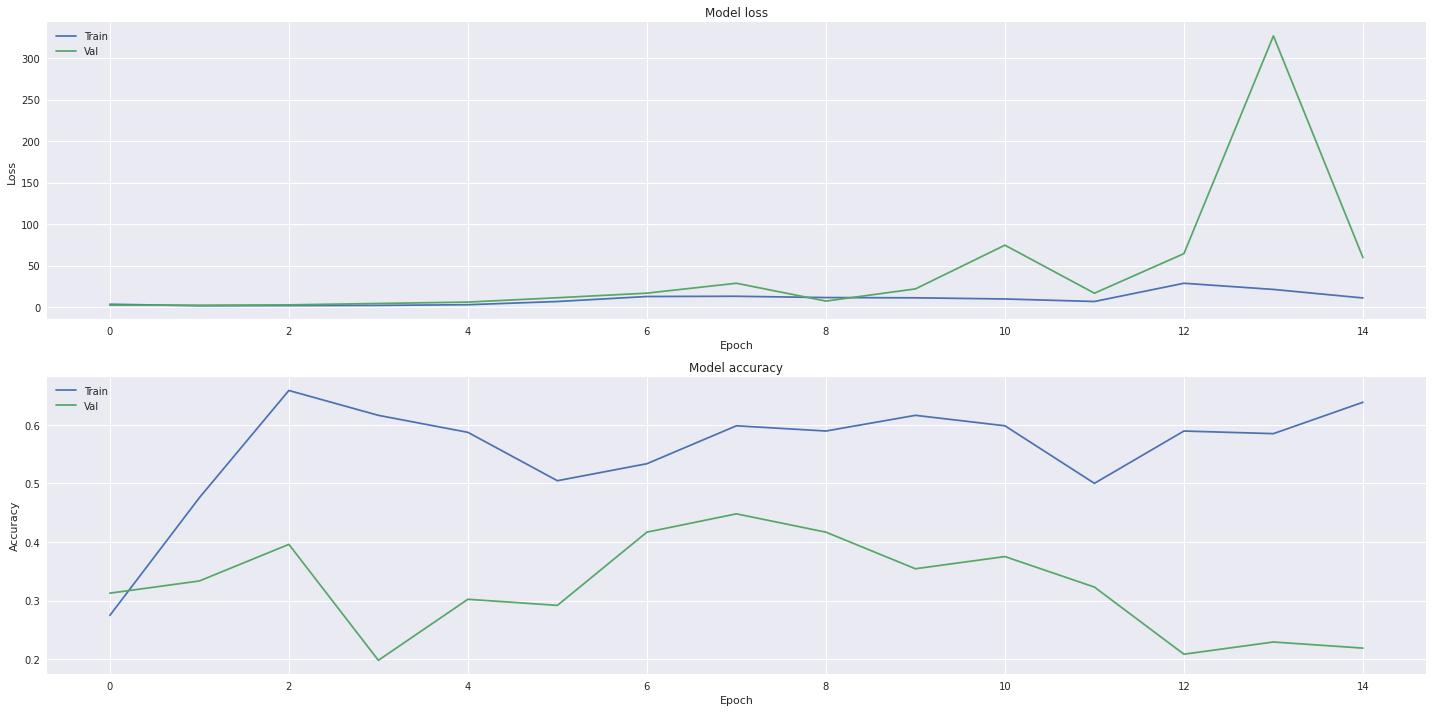

In [27]:
f,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

f.tight_layout()
plt.show()

# Submission

In [28]:
submission = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [29]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator =  datagen.flow_from_dataframe(
    submission,
    directory="../input/plant-pathology-2021-fgvc8/test_images",
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)

Found 3 validated image filenames.


In [30]:
train_generator.class_indices.items()

dict_items([('complex', 0), ('frog_eye_leaf_spot', 1), ('healthy', 2), ('powdery_mildew', 3), ('rust', 4), ('scab', 5)])

In [31]:
def get_key(val):
    for key, value in train_generator.class_indices.items():
        if val == value:
            return key

In [32]:
preds = model.predict(test_generator)
print(preds)

[[8.5109629e-02 8.5978663e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  5.5103719e-02]
 [9.9607676e-01 3.9186152e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.5837483e-06]
 [1.8381056e-01 8.1617463e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.4775200e-05]]


In [33]:
get_key(0)

'complex'

In [34]:
preds[0]>=0.3

array([False,  True, False, False, False, False])

In [35]:
def get_preds_to_labels(preds):
    pred_lists = []
    for pred in preds:
        pred_list = []
        health = pred>=0.4
        sub = (pred>=0.28)
        # get healthy
        if health.sum()==0:
            label = 'healthy'
            pred_list.append(label)
            
        elif pred[2]>=0.5:
            label = 'healthy'
            pred_list.append(label)
            
        # get eles label
        else:
            for j, sub in enumerate(pred):
                if sub>=0.3:
                    label = get_key(j)
                    pred_list.append(label)
                               
        pred_lists.append(' '.join(pred_list))
    return pred_lists

In [36]:
preds_list = get_preds_to_labels(preds)

In [37]:
preds

array([[8.5109629e-02, 8.5978663e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.5103719e-02],
       [9.9607676e-01, 3.9186152e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 4.5837483e-06],
       [1.8381056e-01, 8.1617463e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.4775200e-05]], dtype=float32)

In [38]:
submission['labels'] = preds_list
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,frog_eye_leaf_spot
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot


In [39]:
submission.to_csv('submission.csv', index=False)

#### THX to Reading My Notebook🌈